In [1]:
!pip install keras_vggface

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
import os
import numpy as np
import tensorflow as tf
import keras
from keras.engine import  Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten
from keras import optimizers
from keras_vggface.vggface import VGGFace
from keras.callbacks import ReduceLROnPlateau
from sklearn.utils import class_weight # For balancing the class_weights

Using TensorFlow backend.


In [4]:
print(tf.__version__)
print(keras.__version__)

1.15.2
2.3.1


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation

In [6]:
# data are in dataset folder in zipped format
!ls "drive/My Drive/ENGR635-Deep Learning System Design Project/Dataset/fer2013/"

fer2013.csv  PrivateTest.zip  PublicTest.zip  Training.zip


In [7]:
!ls 

drive  sample_data


In [8]:
# This creates a temporary folder in drive root folder, so it will have to be reloaded again when required after terminating the session
# Permanent data are stored in dataset in zipped format
# This copies the zipped file and store in root of google drive temporarily
! rm -rf Training; mkdir Training
! unzip -q "drive/My Drive/ENGR635-Deep Learning System Design Project/Dataset/fer2013/Training.zip" -d Training

! rm -rf Validation; mkdir Validation
! unzip -q "drive/My Drive/ENGR635-Deep Learning System Design Project/Dataset/fer2013/PublicTest.zip" -d Validation

! rm -rf Test; mkdir Test
! unzip -q "drive/My Drive/ENGR635-Deep Learning System Design Project/Dataset/fer2013/PrivateTest.zip" -d Test

In [9]:
!ls

drive  sample_data  Test  Training  Validation


In [10]:
!ls -l Training/

total 820
drwxr-xr-x 2 root root 126976 Oct 11 05:04 Angry
drwxr-xr-x 2 root root  16384 Oct 11 05:04 Disgust
drwxr-xr-x 2 root root 135168 Oct 11 05:04 Fear
drwxr-xr-x 2 root root 204800 Oct 11 05:04 Happy
drwxr-xr-x 2 root root 135168 Oct 11 05:04 Neutral
drwxr-xr-x 2 root root 135168 Oct 11 05:04 Sad
drwxr-xr-x 2 root root  86016 Oct 11 05:04 Surprise


In [11]:
%%bash
root='Training/'
IFS=$(echo -en "\n\b")
(for dir in $(ls -1 "$root")
    do printf "$dir: " && ls -i "$root$dir" | wc -l
 done)

Angry: 3995
Disgust: 436
Fear: 4097
Happy: 7215
Neutral: 4965
Sad: 4830
Surprise: 3171


In [12]:
%%bash
root='Validation/'
IFS=$(echo -en "\n\b")
(for dir in $(ls -1 "$root")
    do printf "$dir: " && ls -i "$root$dir" | wc -l
 done)

Angry: 467
Disgust: 56
Fear: 496
Happy: 895
Neutral: 607
Sad: 653
Surprise: 415


In [13]:
%%bash
root='Test/'
IFS=$(echo -en "\n\b")
(for dir in $(ls -1 "$root")
    do printf "$dir: " && ls -i "$root$dir" | wc -l
 done)

Angry: 491
Disgust: 55
Fear: 528
Happy: 879
Neutral: 626
Sad: 594
Surprise: 416


In [14]:
train_dir = "Training/"
validation_dir = "Validation/"
test_dir = "Test/"

## All data are ready

In [15]:
# https://github.com/rcmalli/keras-vggface#projects--blog-posts
conv_base = VGGFace(model='vgg16',
                  include_top = False,
                  input_shape = (120,120,3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58916864/58909280 [==============================] - 6s 0us/step


In [16]:
conv_base.summary()

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 120, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 120, 120, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 120, 120, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 60, 60, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 60, 60, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 60, 60, 128)       147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 30, 30, 128)     

In [17]:
DROP_OUT_RATE = 0.5
FROZEN_LAYER_NUM = len(conv_base.layers)
FROZEN_LAYER_NUM

19

In [18]:
print("Number of trainable weights before freezing the conv base:", len(conv_base.trainable_weights))

Number of trainable weights before freezing the conv base: 26


In [19]:
# conv_base.trainable = False
for i in range(FROZEN_LAYER_NUM):
    conv_base.layers[i].trainable = False

In [20]:
print("Number of trainable weights after freezing the conv base:", len(conv_base.trainable_weights))

Number of trainable weights after freezing the conv base: 0


In [21]:
print(conv_base.get_layer('conv5_3').trainable)

False


In [22]:
conv_base.summary()

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 120, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 120, 120, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 120, 120, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 60, 60, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 60, 60, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 60, 60, 128)       147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 30, 30, 128)     

In [30]:
last_layer = conv_base.get_layer('pool5').output

x = Flatten(name='flatten')(last_layer)
x = Dropout(DROP_OUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc6')(x)
# x = Dropout(DROP_OUT_RATE)(x)
# x = Dense(256, activation='relu', name='fc7')(x)
out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(conv_base.input, out)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001,), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 120, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 120, 120, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 120, 120, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 60, 60, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 60, 60, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 60, 60, 128)       147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 30, 30, 128)       0   

In [25]:
# Image Data Generator setup
train_datagen = ImageDataGenerator(rescale=1./255,
                                   featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=90,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True
                                   )
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (120, 120),
    batch_size = 50,
    shuffle = True,
    class_mode='categorical'
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (120, 120),
    batch_size = 50,
    class_mode = 'categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (100, 100),
    batch_size = 50,
    class_mode = 'categorical'
)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [26]:
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
{'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
{'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}


In [27]:
# # Balancing the class weights
# data = np.genfromtxt("/content/drive/My Drive/ENGR635-Deep Learning System Design Project/Dataset/fer2013/fer2013.csv", delimiter=',',dtype=None, encoding='utf8')
# print(data.shape)
# print(data[0])

# # Putting labels
# y_train = data[1:, 0].astype(np.int8)
# print(y_train.shape)
# print(y_train)
# print(np.unique(y_train, return_counts=True))

# # Computing balanced class weights using scikit learn compute_class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                   np.unique(y_train),
#                                                   y_train)

# print(class_weights)
# del data # For saving memory
def class_weight_computer():
  """
    Training Data categories and number of samples in them
    Angry: 3995
    Disgust: 436
    Fear: 4097
    Happy: 7215
    Neutral: 4965
    Sad: 4830
    Surprise: 3171
  """
  samples_per_label = [3995, 436, 4097, 7215, 4965, 4830, 3171]
  total_samples = sum(samples_per_label)
  return [total_samples/(7*i) for i in samples_per_label] # https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html
class_weight_computer()

[1.0266046844269623,
 9.406618610747051,
 1.0010460615781582,
 0.5684387684387684,
 0.8260394187886635,
 0.8491274770777877,
 1.293372978330405]

In [28]:
class_weights = class_weight_computer()
print(class_weights)

[1.0266046844269623, 9.406618610747051, 1.0010460615781582, 0.5684387684387684, 0.8260394187886635, 0.8491274770777877, 1.293372978330405]


In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=28709//50,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=3589//50,
    shuffle=True,
    class_weight=class_weights,
    callbacks=[reduce_lr]
)

Epoch 1/30
573/574 [============================>.] - ETA: 0s - loss: 1.5615 - accuracy: 0.3870

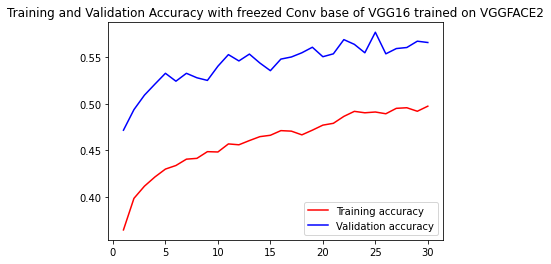

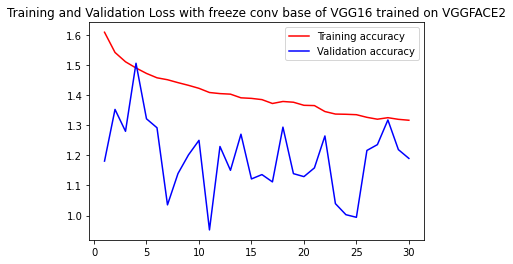

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'r', label="Training accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation accuracy")
plt.title('Training and Validation Accuracy with freezed Conv base of VGG16 trained on VGGFACE2')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label="Training accuracy")
plt.plot(epochs, val_loss, 'b', label="Validation accuracy")
plt.title('Training and Validation Loss with freeze conv base of VGG16 trained on VGGFACE2')
plt.legend()
plt.show()

In [ ]:
print('\nEvaluate on Validation data')
results_validation = model.evaluate_generator(validation_generator, 3589//50 )
print('Validation loss, Validation Accuracy:', results_validation)


Evaluate on Validation data
Validation loss, Validation Accuracy: [1.2088897228240967, 0.5676056146621704]


In [ ]:
print('\nEvaluate on test data')
results_test = model.evaluate_generator(test_generator, 3589//50)
print('test loss, test acc:', results_test)


Evaluate on test data
test loss, test acc: [1.042024850845337, 0.5695774555206299]


In [ ]:
EPOCHS = 30
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = 'test_acc_%.3f' % results_test[1]

In [ ]:
# Saving the model
model.save("drive/My Drive/ENGR635-Deep Learning System Design Project/Models/" + 'VGG16' + epoch_str + test_acc + '.h5')